<a href="https://colab.research.google.com/github/Bookanakere/Explore_FastAI/blob/main/Copy_of_02_production.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#hide
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 727kB 6.8MB/s 
     |████████████████████████████████| 204kB 57.8MB/s 
     |████████████████████████████████| 51kB 6.8MB/s 
     |████████████████████████████████| 1.2MB 47.6MB/s 
     |████████████████████████████████| 61kB 8.5MB/s 
     |████████████████████████████████| 61kB 10.1MB/s 
Mounted at /content/gdrive


In [2]:
#hide
from fastbook import *
from fastai.vision.widgets import *

In [3]:
key = os.environ.get('AZURE_SEARCH_KEY', 'be027a26a87f4c8eae38be1de8f9422c')

In [4]:
results = search_images_bing(key, 'grizzly bear')
ims = results.attrgot('contentUrl')
len(ims)

150

In [5]:
#hide
ims = ['http://3.bp.blogspot.com/-S1scRCkI3vY/UHzV2kucsPI/AAAAAAAAA-k/YQ5UzHEm9Ss/s1600/Grizzly%2BBear%2BWildlife.jpg']

In [6]:
import os
os.mkdir('images')

In [7]:
dest = 'images/grizzly.jpg'
download_url(ims[0], dest)

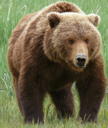

In [8]:
im = Image.open(dest)
im.to_thumb(128,128)

In [9]:
bear_types = 'grizzly','black','teddy'
path = Path('bears')

In [10]:
if not path.exists():
    path.mkdir()
    for o in bear_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{o} bear')
        download_images(dest, urls=results.attrgot('contentUrl'))

In [19]:
fns = get_image_files(path)
fns

(#395) [Path('bears/black/00000082.jpg'),Path('bears/black/00000060.jpg'),Path('bears/black/00000093.jpg'),Path('bears/black/00000014.jpg'),Path('bears/black/00000047.jpg'),Path('bears/black/00000086.png'),Path('bears/black/00000065.jpg'),Path('bears/black/00000115.jpg'),Path('bears/black/00000042.jpg'),Path('bears/black/00000147.jpg')...]

In [20]:
failed = verify_images(fns)
failed.map(Path.unlink);

In [21]:
bears = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [22]:
dls = bears.dataloaders(path)

In [23]:
bears = bears.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = bears.dataloaders(path)

In [24]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.533202,0.111167,0.025974,00:20


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


epoch,train_loss,valid_loss,error_rate,time
0,0.297231,0.029452,0.012987,00:20
1,0.194470,0.024816,0.012987,00:20
2,0.150199,0.021036,0.012987,00:20
3,0.114862,0.016384,0.012987,00:20


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency e

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


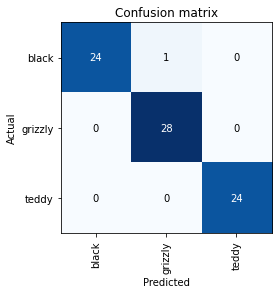

In [25]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

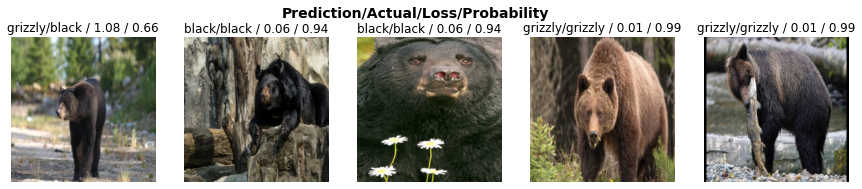

In [26]:
interp.plot_top_losses(5, nrows=1)

In [27]:
learn.export()

In [28]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [29]:
learn_inf = load_learner(path/'export.pkl')

When we're doing inference, we're generally just getting predictions for one image at a time. To do this, pass a filename to `predict`:

In [30]:
learn_inf.predict('images/grizzly.jpg')

('grizzly', tensor(1), tensor([2.1505e-03, 9.9783e-01, 2.4553e-05]))

In [31]:
learn_inf.dls.vocab[1]

'grizzly'

In [32]:
#hide
from fastai.vision.all import *
from ipywidgets import widgets 
from fastai.vision.widgets import *

In [33]:
path = Path()

In [34]:
btn_upload = SimpleNamespace(data = ['images/grizzly.jpg'])

In [35]:
img = PILImage.create(btn_upload.data[-1])

In [36]:
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))

In [37]:
pred,pred_idx,probs = learn_inf.predict(img)

In [38]:
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

In [39]:
btn_run = widgets.Button(description='Classify')

In [40]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [41]:
btn_upload = widgets.FileUpload()

In [ ]:
VBox([widgets.Label('Select your bear!'), 
      btn_upload, btn_run, out_pl, lbl_pred])